## Character Sampling Math

40 characters -> 24 images

4 characters per batch, 4 images per character per batch

960 train images

960 / 16 = 60 batches to be sampled

Each batch  -> 4 characters -> 60 * 4 = 240 total character samplings

320 validation images

320 / 40 -> 8 times per character is sampled

# Create Cover Page Sprite

In [1]:
import PIL.Image
import random
import os
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
src_pth = "/home/vinayak/cleaned_anime_faces"

all_files = []
for root, dirs, files in os.walk(src_pth):
    if files:
        all_files.append(os.path.join(root, random.sample(files, 1)[0]))    

In [3]:
images = []
for item in all_files:
    images.append(PIL.Image.open(item))

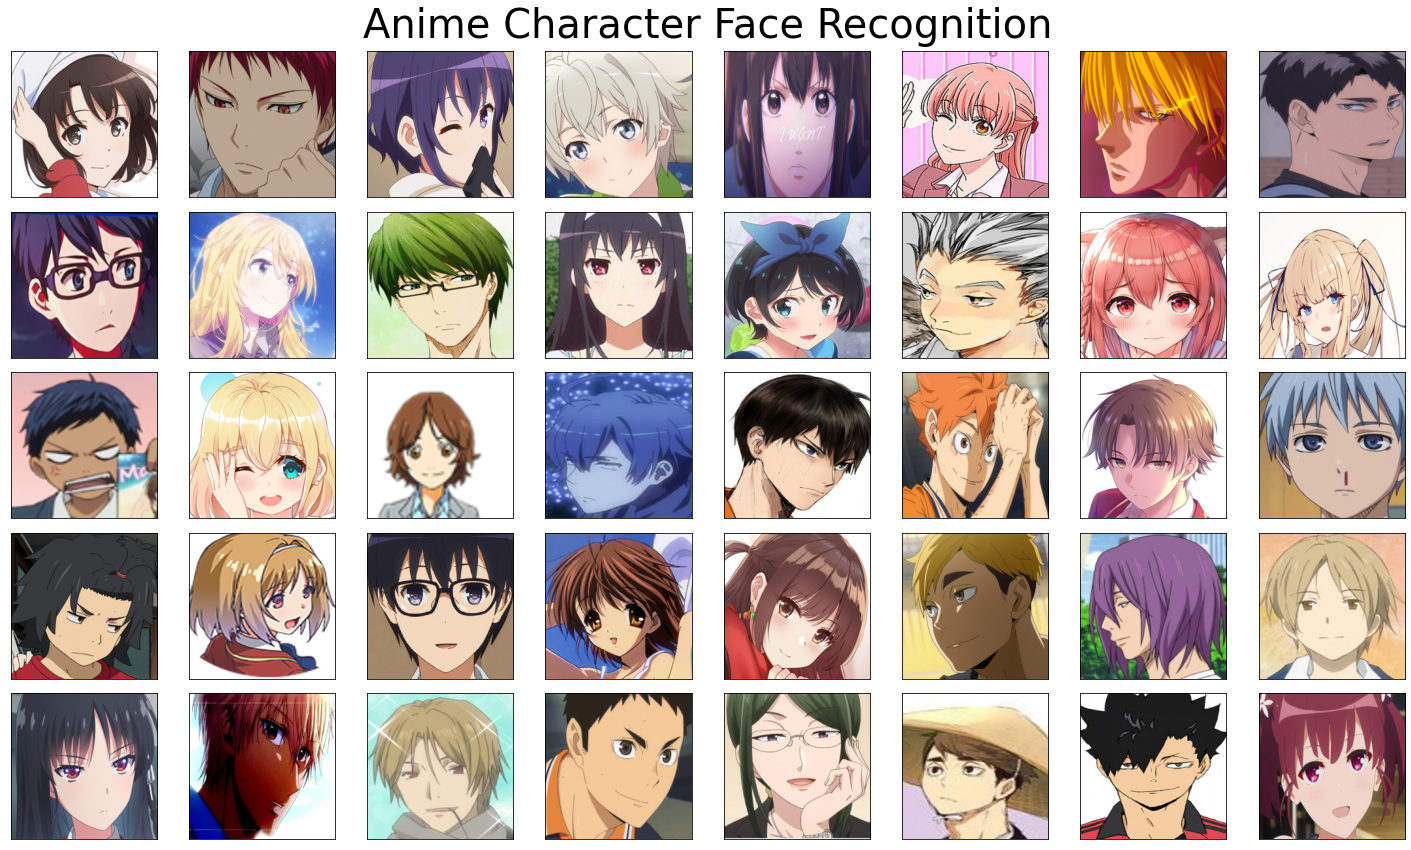

In [4]:
fig, ax = plt.subplots(5, 8, figsize = (20, 12))
ax = np.ravel(ax)

for idx, axis in enumerate(ax):
    disp_img = images[idx].resize((225, 225))
    axis.imshow(disp_img)
    axis.set_xticks([])
    axis.set_yticks([])

fig.suptitle("Anime Character Face Recognition", fontsize = 40)
plt.savefig("./anime_faces_3.png")
fig.tight_layout();

# Evaluate the results and find hardest/easiest searchable characters

In [59]:
import numpy as np
import pandas as pd
import pickle
from sklearn.metrics import pairwise_distances

# Mention the path to the extracted feature vectors here
FV_PATH = "/home/vinayak/anime_feature_vectors_valid.pkl"

with open(FV_PATH, "rb") as f:
    data = pickle.load(f)
    f.close()

In [60]:
# A function to compute the topk accuracy given a distance matrix and the lab
def get_neighbours(distance_matrix, filenames, k = 1):
    
    neighbours = {}
    get_fname = lambda x: filenames[x]
    count = 0
    
    # Find the k nearest neighbours for every query image in the distance matrix
    for idx, vector in enumerate(distance_matrix):
        ranking = np.argsort(vector)
        indices = ranking[1:(k + 1)]
        
        neighbours[get_fname(idx)] = [get_fname(x) for x in indices]
            
    return neighbours

In [61]:
# Extract feature vectors and calculate pairwise distances of every vector from every other vector
files = list(data.keys())
fvs = np.array(list(data.values()))
distances = pairwise_distances(fvs, n_jobs = -1)

neighbours = get_neighbours(distances, files, 5)

In [62]:
# Get a measure of the accuracy in terms of retrieval on a per character basis

character_retrieval_mapping = {}
get_character = lambda x: x.split("/")[-2]

for item in neighbours:
    
    character = get_character(item)
    if not (character in character_retrieval_mapping):
        character_retrieval_mapping[character] = []
    
    n_nbrs = sum([1 * (get_character(x) == character) for x in neighbours[item]])
    character_retrieval_mapping[character].append(n_nbrs)

In [63]:
characters = []
matches_array = []
avg_retrieval_score = []

for character, matches in character_retrieval_mapping.items():
    
    characters.append(character)
    matches_array.append(matches)
    avg_retrieval_score.append(float(sum(matches)) / len(matches))

data = pd.DataFrame({"characters": characters,
                     "retrieval score": avg_retrieval_score,
                     "matches": matches_array,})

data = data.sort_values(by = ["retrieval score"])

In [64]:
data.to_csv("./valid_retrieval_results.csv", index = False)

# Visualize the results of image retrieval 

# Cluster the results together by their distances and visualise their t-SNE embeddings

In [123]:
import numpy as np
import pandas as pd
import pickle
from sklearn.manifold import TSNE
import seaborn as sns
# Mention the path to the extracted feature vectors here
FV_PATH = "/home/vinayak/anime_feature_vectors_valid.pkl"

with open(FV_PATH, "rb") as f:
    data = pickle.load(f)
    f.close()

In [124]:
validation_classes = [x.split("/")[-2] for x in list(data.keys())]
validation_embeddings = np.array(list(data.values()))

In [125]:
tsne_embeddings = TSNE(n_components=2).fit_transform(validation_embeddings)

In [126]:
df = {"tsne-component-one": tsne_embeddings[:, 0],
      "tsne-component-two": tsne_embeddings[:, 1],
      "y": validation_classes}

df = pd.DataFrame(df)

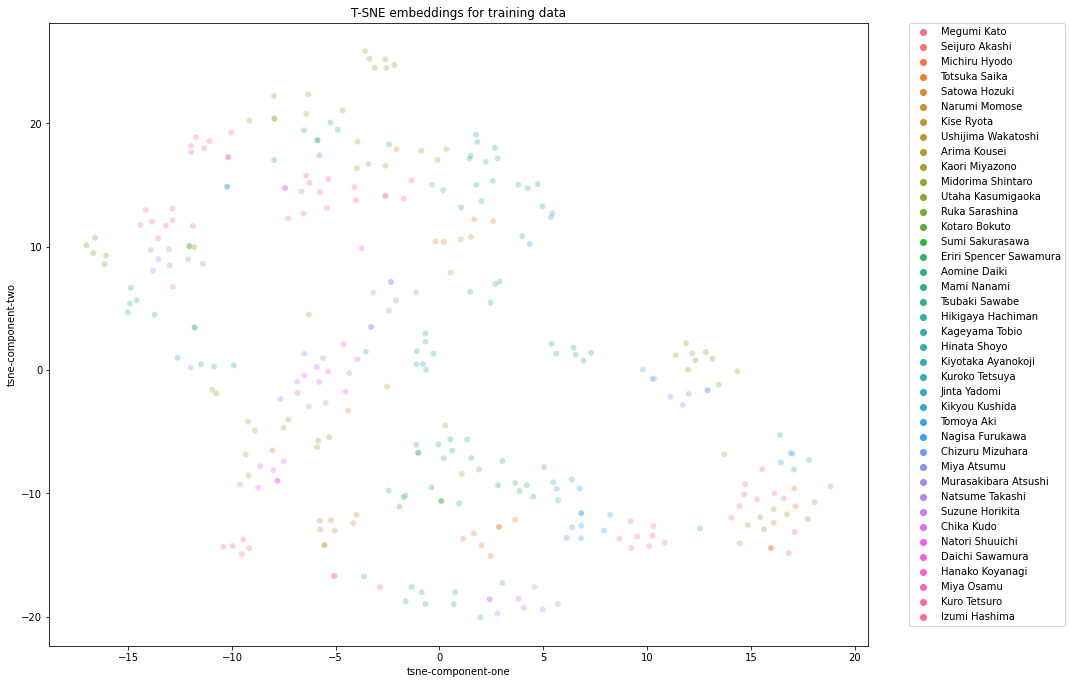

In [127]:
plt.figure(figsize=(15,10))
sns.scatterplot(
    x="tsne-component-one", y="tsne-component-two",
    hue="y",
    palette=sns.color_palette("husl", 40),
    data=df,
    legend="full",
    alpha=0.3
)

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title("T-SNE embeddings for training data")
plt.tight_layout()
plt.savefig("valid_data_tsne_plot.png");